In [2]:
%gui qt5

import math
import matplotlib.pyplot as plt
import napari
import numpy as np
import os
import skimage.filters as filters
import skimage.io as io


from PIL import Image
#Commenting out oasis because it can be tricky to install
#from oasis.functions import gen_data, gen_sinusoidal_data, deconvolve, estimate_parameters
#from oasis.plotting import simpleaxis


import scipy.signal as signal
from scipy import integrate


In [3]:
# Change output figure size
# ...needs to be in its own cell for some reason...

plt.rcParams['figure.figsize'] = [16, 10]

In [5]:
def folder2tif(dir_path):
    final = []
    files = os.listdir(dir_path)
    files = sorted(files)
    for fname in files:
        im = Image.open(os.path.join(dir_path, fname))
        imarray = np.array(im)
        final.append(imarray)
    final = np.asarray(final)
    return final

# Returns change in fluorescence over average fluorescence of ROI
def deltaF(video_mask):
    video_mask_nan = video_mask.copy()
    video_mask_nan[video_mask_nan==0] = np.nan
    mean = np.mean(np.nanmean(video_mask))
    print(mean)
    dff= np.zeros((video_mask.shape[0]))
    for i in range(dff.shape[0]):
        delta = np.nanmean(video_mask[i, :, :])-mean
        dff[i] = delta/mean
    return dff

# Returns raw values fluorescence in the ROI
def rawIntensity(video_mask):
    video_mask_nan = video_mask.copy()
    video_mask_nan[video_mask_nan==0] = np.nan
    mean = np.nanmean(video_mask, axis=(1,2))
    return mean

In [6]:
# Import the movies provide the path to the folder containing the frames

gcamp = folder2tif("osfstorage-archive/Data (Images)/Cell 14_YAC128_G/")
rcamp = folder2tif("osfstorage-archive/Data (Images)/Cell 14_YAC128_R/")

In [8]:
# Inspect both videos in Napari
overlay = napari.Viewer()
overlay.add_image(gcamp, name="nuclear", colormap="magenta")
overlay.add_image(rcamp, name="cytosol", blending="additive", colormap="cyan")


<Image layer 'cytosol' at 0x7ff93828d780>

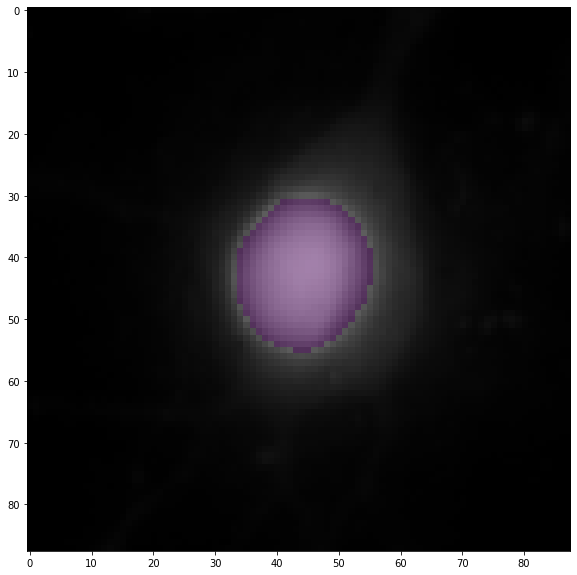

In [7]:
# To create a ROI for the nucleus a STD projection is created
# Thresholding this image creates a mask for the roi

std_projectionG = np.std(gcamp, axis=0)
threshold = filters.threshold_otsu(std_projectionG)
std_projectionG[std_projectionG < threshold] = 0
std_projectionG[std_projectionG>0]=1

mask_G=std_projectionG.copy()
mask_G[mask_G==0]=np.nan
plt.imshow(np.std(gcamp, axis=0), cmap='gray')
plt.imshow(mask_G, cmap='viridis', alpha=.5)


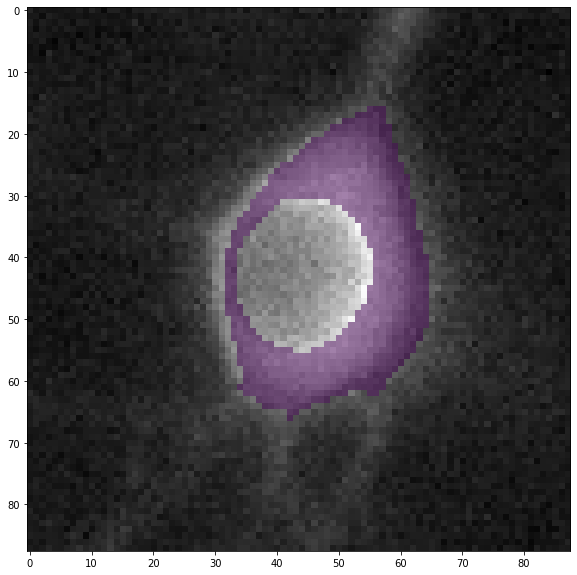

In [9]:
# Create a ROI for the cytosl using an STD projection 
# Thresholding this image creates a mask for the roi
std_projectionR = np.std(rcamp, axis=0)
threshold = filters.threshold_otsu(std_projectionR)
std_projectionR[std_projectionR < threshold] = 0
std_projectionR[std_projectionR>0]=1
# Remove the Nuclear Mask from this ROI
std_projectionR[std_projectionG==1]=0

mask_R=std_projectionR.copy()
mask_R[mask_R==0]=np.nan
plt.imshow(rcamp[500,: :], cmap='gray')
plt.imshow(mask_R, cmap='viridis', alpha=.5)

In [10]:
# Applying the masks for the two channels
gcamp_masked = gcamp * std_projectionG
rcamp_masked = rcamp * std_projectionR

In [12]:
# Insepect the results for Nuclear GCaMP
gcamp_insepction = napari.Viewer()
gcamp_insepction.add_image(gcamp, name="No Mask", colormap="magenta")
gcamp_insepction.add_image(gcamp_masked, name="Masked", blending="additive", colormap="cyan")


<Image layer 'Masked' at 0x7ff918f599b0>

In [13]:
# Insepect the results for Cytosolic RCaMP

overlay = napari.Viewer()
overlay.add_image(rcamp, name="No Mask", colormap="magenta")
overlay.add_image(rcamp_masked, name="Masked", blending="additive", colormap="cyan")


<Image layer 'Masked' at 0x7ff9184e8a20>

In [14]:
# Look at both masked movies together
overlay = napari.Viewer()
overlay.add_image(gcamp_masked, name="GCaMP", colormap="magenta")
overlay.add_image(rcamp_masked, name="RCaMP", blending="additive", colormap="cyan")


<Image layer 'RCaMP' at 0x7ff918213e48>

17.048936863971083


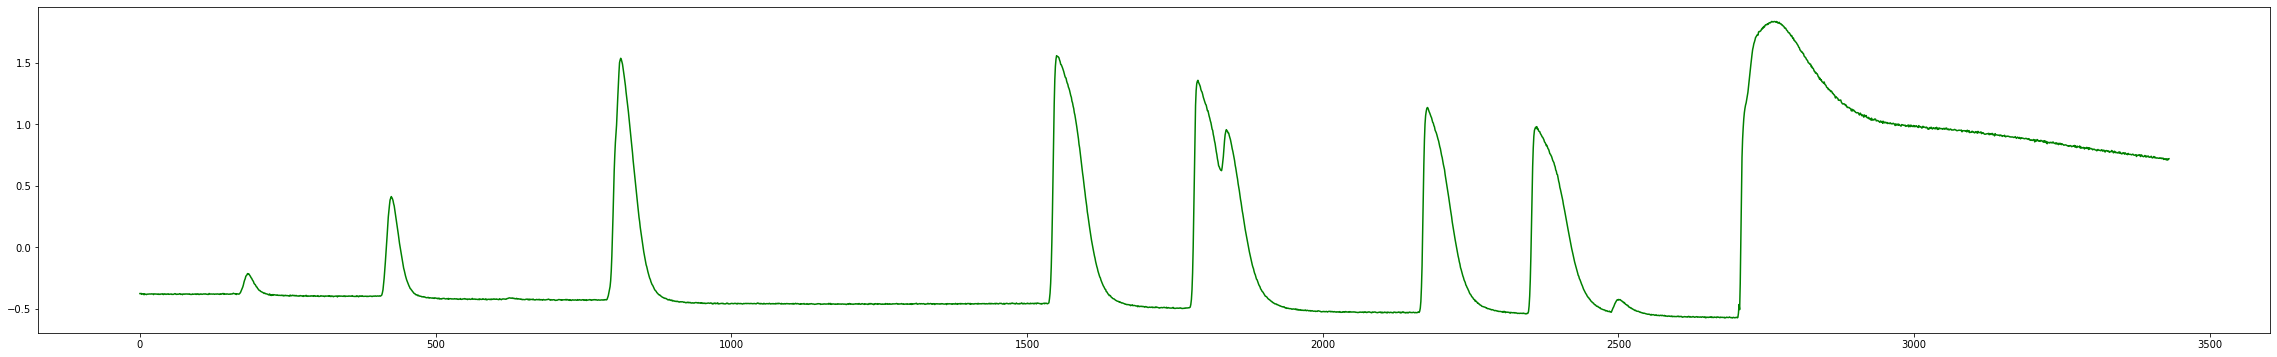

In [16]:
# Getting the DDF for GCaMP ROI, fitting & spike detection w oasis
gcamp_dff = deltaF(gcamp_masked)
plt.figure(figsize=(40,6))

plt.plot(gcamp_dff, c='g')

25.952056084626463
25.952056084626463


<Figure size 2880x432 with 0 Axes>

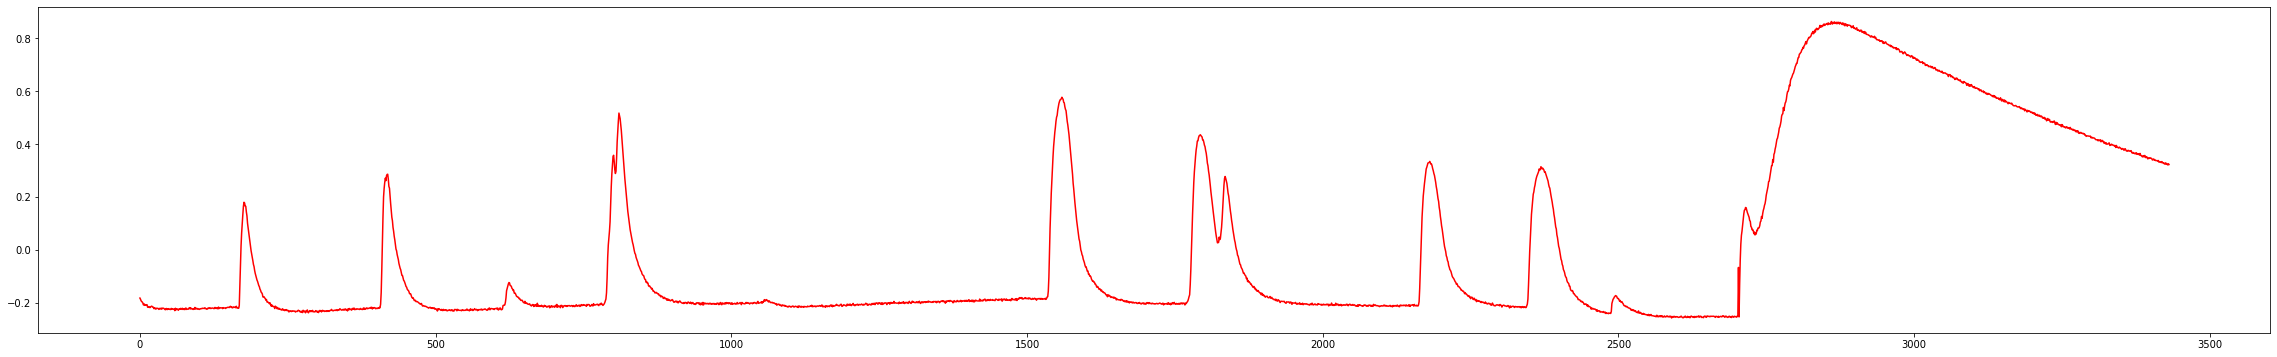

In [15]:
# Getting the DDF for RCaMP ROI, fitting & spike detection w oasis
rcamp_raw=rawIntensity(rcamp_masked)
rcamp_dff = deltaF(rcamp_masked)
plt.figure(figsize=(40,6))
plt.figure(figsize=(40,6))

plt.plot(rcamp_dff, c='r')



0.6834926977092003
(9,)


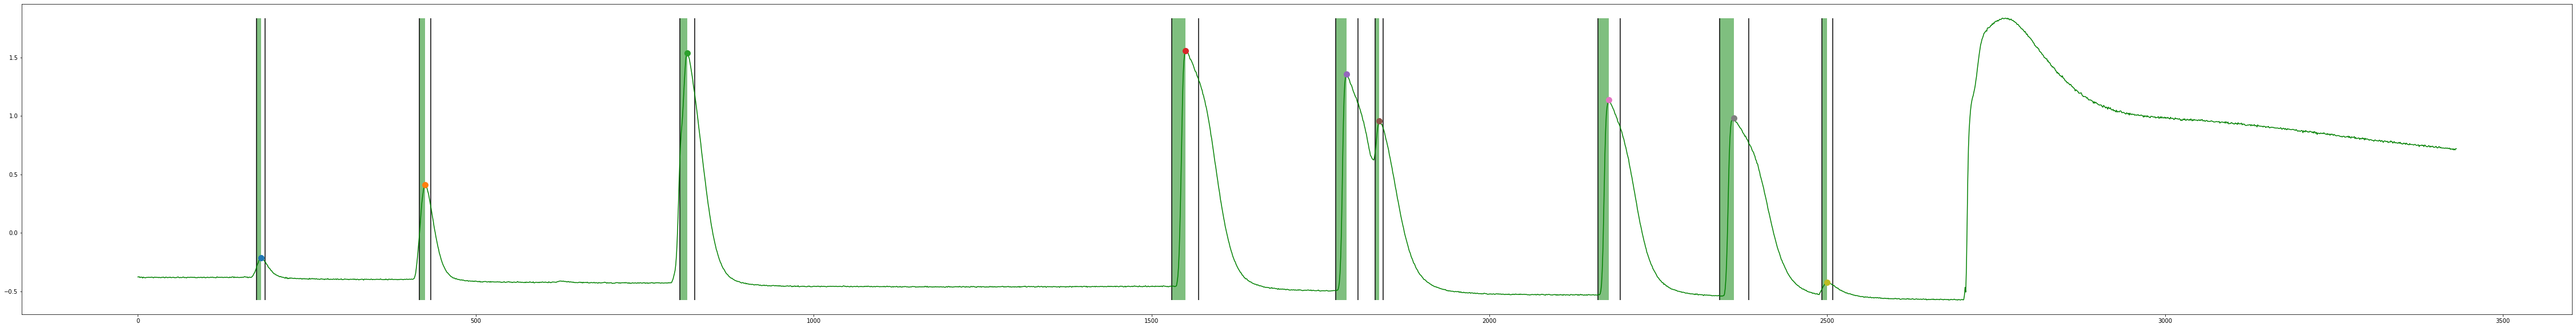

In [19]:
# Detect Peaks
gcamp_threshold =np.std(gcamp_dff)
gcamp_peaks, _ = signal.find_peaks(gcamp_dff, width=7, rel_height=.5, prominence=(.1*gcamp_threshold))
gcamp_peaks =  gcamp_peaks[:-1]
gcamp_width = signal.peak_widths(gcamp_dff, gcamp_peaks, rel_height=.1)
gcamp_width = (gcamp_width[0])


# Plot Peaks
fig, ax = plt.subplots(figsize=(80,10))
ax.plot(gcamp_dff, color='g')
for line in range(gcamp_width.shape[0]):
    ax.plot(gcamp_peaks[line], gcamp_dff[gcamp_peaks[line]], "o", markersize=10)
    ax.vlines(x=(gcamp_peaks[line]-gcamp_width[line]),ymin=np.min(gcamp_dff), ymax=np.max(gcamp_dff))
    ax.vlines(x=(gcamp_peaks[line]+gcamp_width[line]),ymin=np.min(gcamp_dff), ymax=np.max(gcamp_dff))
    ax.fill_between(x=[(gcamp_peaks[line]-gcamp_width[line]), (gcamp_peaks[line])],
    y1=np.min(gcamp_dff), y2=np.max(gcamp_dff), facecolor='green', alpha=0.5)

plt.show()

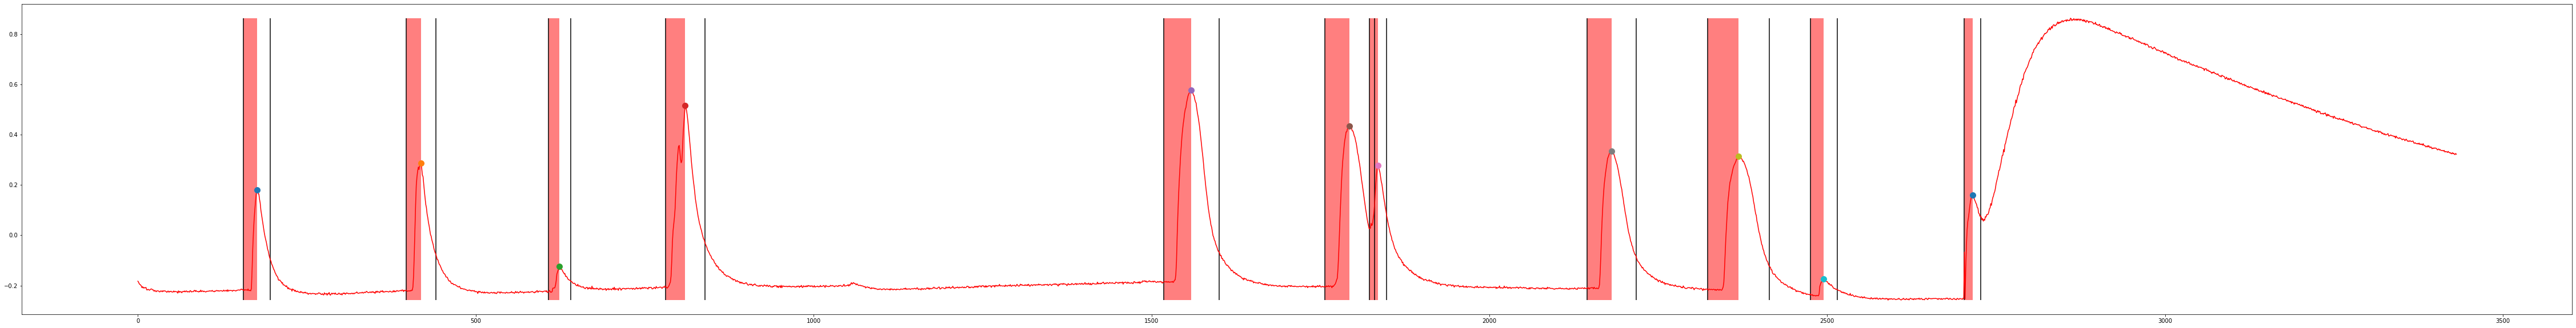

In [20]:
# Detect Peaks
rcamp_threshold =np.std(rcamp_dff)
rcamp_peaks, _ = signal.find_peaks(rcamp_dff, width=7, prominence=(.1*rcamp_threshold))
rcamp_peaks =  rcamp_peaks[:-1]
rcamp_width = signal.peak_widths(rcamp_dff, rcamp_peaks)
rcamp_width = (rcamp_width[0])

# Plot Peaks
fig, ax = plt.subplots(figsize=(80,10))
ax.plot(rcamp_dff, c='r')
for line in range(rcamp_width.shape[0]):
    ax.plot(rcamp_peaks[line], rcamp_dff[rcamp_peaks[line]], "o", markersize=10)
    ax.vlines(x=(rcamp_peaks[line]-rcamp_width[line]),ymin=np.min(rcamp_dff), ymax=np.max(rcamp_dff))
    ax.vlines(x=(rcamp_peaks[line]+rcamp_width[line]),ymin=np.min(rcamp_dff), ymax=np.max(rcamp_dff))
    ax.fill_between(x=[(rcamp_peaks[line]-rcamp_width[line]), (rcamp_peaks[line])],
    y1=np.min(rcamp_dff), y2=np.max(rcamp_dff), facecolor='red', alpha=0.5)

plt.show()

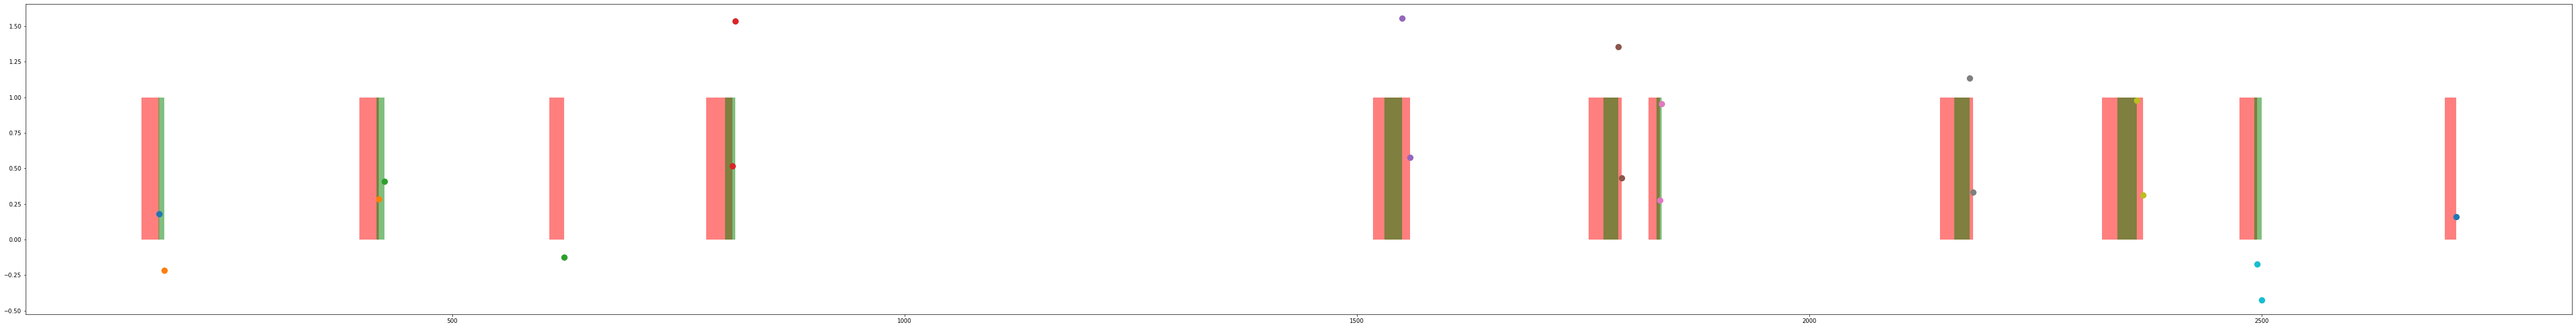

In [21]:
# Plot a comparison of peaks
fig, ax = plt.subplots(figsize=(80,10))
for line in range(rcamp_width.shape[0]):
    ax.plot(rcamp_peaks[line], rcamp_dff[rcamp_peaks[line]], "o", markersize=10)
    ax.fill_between(x=[(rcamp_peaks[line]-rcamp_width[line]), (rcamp_peaks[line])],
    y1=0, y2=1, facecolor='red', alpha=0.5)
for line in range(gcamp_width.shape[0]):
    ax.plot(gcamp_peaks[line], gcamp_dff[gcamp_peaks[line]], "o", markersize=10)
    ax.fill_between(x=[(gcamp_peaks[line]-gcamp_width[line]), (gcamp_peaks[line])],
    y1=0, y2=1, facecolor='green', alpha=0.5)
plt.show()

In [22]:
# Print out the frame that contains a detected peak
print("GCaMP peaks: ", gcamp_peaks, "\n","RCaMP peaks: ", rcamp_peaks)

GCaMP peaks:  [ 182  425  813 1550 1789 1837 2177 2362 2500] 
 RCaMP peaks:  [ 176  419  624  810 1559 1793 1835 2181 2369 2495 2715]


In [23]:
# Match Peaks and puttin them in a list of tuples (g, r)
gcamp_matched= []
for g in gcamp_peaks:
    for r in rcamp_peaks:
        a = math.isclose(g, r, abs_tol=10)
        if a == True:
            gcamp_matched.append((g,r))
            
    

In [24]:
print('Percent of GCaMP shared peaks: ', (len(gcamp_matched)/len(gcamp_peaks)))
print('Percent of RCaMP shared peaks: ', (len(gcamp_matched)/len(rcamp_peaks)))


Percent of GCaMP shared peaks:  1.0
Percent of RCaMP shared peaks:  0.8181818181818182


In [127]:
# Print ratio of peaks (g/r) and the difference in time (r-g)*100ms
for event in gcamp_matched:
    print("r/g: ", rcamp_dff[event[1]]/gcamp_dff[event[0]])
    print((event[0]-event[1])*100,"ms")

r/g:  -0.8373731151150692
600 ms
r/g:  0.6951478166962197
600 ms
r/g:  0.3368380097302152
300 ms
r/g:  0.37069057202081945
-900 ms
r/g:  0.32095357384144374
-400 ms
r/g:  0.2902741604786031
200 ms
r/g:  0.29433392265781805
-400 ms
r/g:  0.32080342936504086
-700 ms
r/g:  0.40794084922030016
500 ms


In [136]:
# Get area under the curve for ris and get start times for shared events
for event in gcamp_matched:
    gindex = np.where(gcamp_peaks == event[0])[0]
    rindex = np.where(rcamp_peaks == event[1])[0]
    g_event_start = int(event[0]-gcamp_width[gindex])
    r_event_start = int(event[0]-rcamp_width[rindex])
    
    g_area = integrate.simps(gcamp_dff[g_event_start:event[0]])
    r_area = integrate.simps(rcamp_dff[r_event_start:event[1]])
    
    print("Difference in peak time (g-r): ", (g_event_start - r_event_start)*100, "ms")
    print("ratio of 1/2 area (r/g): ", (r_area/g_area))

    
    

Difference in peak time (g-r):  1300 ms
ratio of 1/2 area (r/g):  0.7875141246035897
Difference in peak time (g-r):  1300 ms
ratio of 1/2 area (r/g):  0.33826759550149216
Difference in peak time (g-r):  1800 ms
ratio of 1/2 area (r/g):  0.27677865781124705
Difference in peak time (g-r):  2200 ms
ratio of 1/2 area (r/g):  1.513031847985732
Difference in peak time (g-r):  2000 ms
ratio of 1/2 area (r/g):  -0.22825850674995735
Difference in peak time (g-r):  700 ms
ratio of 1/2 area (r/g):  0.28042755063229485
Difference in peak time (g-r):  2000 ms
ratio of 1/2 area (r/g):  -0.9032553835334932
Difference in peak time (g-r):  2400 ms
ratio of 1/2 area (r/g):  -5.672782875508569
Difference in peak time (g-r):  1100 ms
ratio of 1/2 area (r/g):  0.8455417189584491
